<strong><em>Student Academic Performance Prediction:</em></strong><br>
***
This notebook attempts to study some of the factors affecting student academic success, the first measurement of success being the GPA and the second being eligibility for application of a master's degree

Features being studied are:<br>
<t>    -> SAT score <br>
<t>    -> Athletism<br>
<t>    -> High School Size<br>
<t>    -> High School Rank<br>
<t>    -> High School Percentile<br>
<t>    -> Gender<br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import Ridge , LogisticRegression, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import statsmodels.api as sm
from dash import dash, dcc, html, Input, Output
import plotly.express as px


In [38]:
merged_df= pd.read_csv('GPA2.csv')
unchanged_df = pd.read_csv('GPA2.csv') # for the "before" graphs


gpa
4.00    78
3.00    75
2.00    63
2.60    40
2.35    39
        ..
0.76     1
1.67     1
3.79     1
1.45     1
0.21     1
Name: count, Length: 314, dtype: int64


In [3]:
success =[]
successCount = 0;
failCount = 0;
for i in merged_df["gpa"]:
    if(i >= (3)):
        success.append(True)
        successCount+= 1
    else:
        success.append(False)
        failCount+=1

merged_df.insert(7,"Success", success);
print("Succes Count is: ", successCount)
print("Fail Count is: ", failCount)

Succes Count is:  1300
Fail Count is:  2835


In [4]:
merged_df

,gpa,SAT,athlete,hsize,hsrank,hsperc,female,Success
0,2.04,920,1,10,4,40.000000,1,False
1,4.00,1170,0,940,191,20.319150,0,True
2,1.78,810,1,119,42,35.294120,0,False
3,2.42,940,0,571,252,44.133100,0,False
4,2.61,1180,0,214,86,40.186920,0,False
...,...,...,...,...,...,...,...,...
4130,2.24,990,0,233,89,38.197430,1,False
4131,2.46,900,0,10,2,20.000000,1,False
4132,4.00,1340,0,45,1,2.222222,0,True
4133,2.83,980,0,35,23,65.714290,1,False


In [5]:
merged_df.describe()

,gpa,SAT,athlete,hsize,hsrank,hsperc,female
count,4135.000000,4135.000000,4135.000000,4135.000000,4135.000000,4135.000000,4135.000000
mean,2.653969,1030.324063,0.046917,279.882709,52.777993,19.229207,0.449819
std,0.656204,139.422201,0.211486,173.576713,64.636182,16.568810,0.497536
min,0.210000,470.000000,0.000000,3.000000,1.000000,0.166667,0.000000
25%,2.210000,940.000000,0.000000,164.500000,11.000000,6.430659,0.000000
50%,2.660000,1030.000000,0.000000,251.000000,30.000000,14.583330,0.000000
75%,3.120000,1120.000000,0.000000,368.000000,70.000000,27.681105,1.000000
max,4.000000,1540.000000,1.000000,940.000000,634.000000,92.000000,1.000000


In [6]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4135 entries, 0 to 4134
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gpa      4135 non-null   float64
 1   SAT      4135 non-null   int64  
 2   athlete  4135 non-null   int64  
 3   hsize    4135 non-null   int64  
 4   hsrank   4135 non-null   int64  
 5   hsperc   4135 non-null   float64
 6   female   4135 non-null   int64  
 7   Success  4135 non-null   bool   
dtypes: bool(1), float64(2), int64(5)
memory usage: 230.3 KB


In [7]:
# we first check for duplicates:
print("merged duplicated:\n",merged_df[merged_df.duplicated()])
# we found a duplicate in the df, it's student number 533

merged duplicated:
       gpa   SAT  athlete  hsize  hsrank  hsperc  female  Success
533  3.17  1060        0     10       2    20.0       1     True


In [8]:
#idk why this messes up when we try to work on it later, someone check this plz
merged_df= merged_df.drop_duplicates()
#here we saved the merged_df without the duplicate
merged_df.info()
#we can notice that the data is now one entry less.

<class 'pandas.core.frame.DataFrame'>
Index: 4134 entries, 0 to 4134
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gpa      4134 non-null   float64
 1   SAT      4134 non-null   int64  
 2   athlete  4134 non-null   int64  
 3   hsize    4134 non-null   int64  
 4   hsrank   4134 non-null   int64  
 5   hsperc   4134 non-null   float64
 6   female   4134 non-null   int64  
 7   Success  4134 non-null   bool   
dtypes: bool(1), float64(2), int64(5)
memory usage: 262.4 KB


In [9]:
# do this again after the duplicate is gone
merged_df.describe()
#we can conclude a few things from this. for example, nearly half of these students are female, 
#and almost 5% only are athletes

,gpa,SAT,athlete,hsize,hsrank,hsperc,female
count,4134.000000,4134.000000,4134.000000,4134.000000,4134.000000,4134.000000,4134.000000
mean,2.653844,1030.316884,0.046928,279.947992,52.790276,19.229020,0.449686
std,0.656234,139.438302,0.211510,173.546932,64.639175,16.570810,0.497522
min,0.210000,470.000000,0.000000,3.000000,1.000000,0.166667,0.000000
25%,2.210000,940.000000,0.000000,165.000000,11.000000,6.429615,0.000000
50%,2.660000,1030.000000,0.000000,251.000000,30.000000,14.579800,0.000000
75%,3.120000,1120.000000,0.000000,368.000000,70.000000,27.686707,1.000000
max,4.000000,1540.000000,1.000000,940.000000,634.000000,92.000000,1.000000


In [37]:

# Create Dash app
app = dash.Dash(__name__)

# Define layout
app.layout = html.Div([
    html.H1("Data Visualization Dashboard"),
    html.Div([
        dcc.Dropdown(
            id='x-variable',
            options=[{'label': col, 'value': col} for col in unchanged_df.columns[1:]],
            value=unchanged_df.columns[1],  # Default value
            clearable=False,
        ),
        dcc.RadioItems(
            id='plot-type',
            options=[
                {'label': 'Scatter Plot', 'value': 'scatter'},
                {'label': 'Bar Plot', 'value': 'bar'},
                {'label': 'Line Plot', 'value': 'line'}
            ],
            value='scatter',  # Default value
            labelStyle={'display': 'block'}
        ),
    ], style={'width': '50%', 'margin': 'auto', 'textAlign': 'center'}),
    dcc.Graph(id='graph')
])

# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input('x-variable', 'value'),
     Input('plot-type', 'value')]
)
def update_graph(x_variable, plot_type):
    if plot_type == 'scatter':
        fig = px.scatter(unchanged_df, x=x_variable, y='gpa', title=f'gpa vs {x_variable}')
    elif plot_type == 'bar':
        fig = px.bar(unchanged_df, x=x_variable, y='gpa', title=f'gpa vs {x_variable}')
    elif plot_type == 'line':
        fig = px.line(unchanged_df, x=x_variable, y='gpa', title=f'gpa vs {x_variable}')
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True,port=8006)


Bins number using Rice Rule is :  61


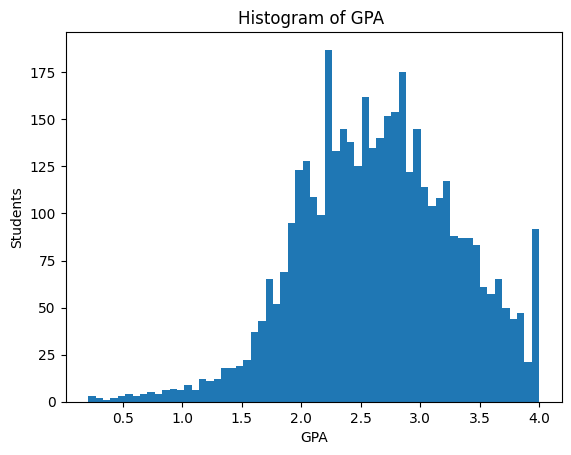

In [39]:
bin_num=2*np.cbrt(unchanged_df.size)
print("Bins number using Rice Rule is : ",int(bin_num))
plt.hist(unchanged_df['gpa'],bins=int(bin_num))
plt.xlabel('GPA')
plt.ylabel('Students')
plt.title('Histogram of GPA ')
plt.show()


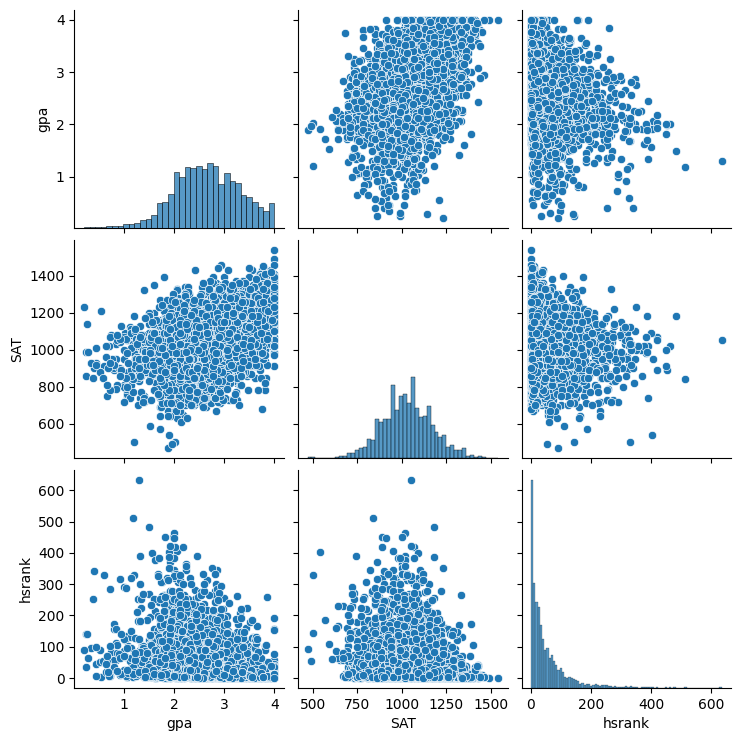

In [13]:
#this looks cool ig?
sns.pairplot(merged_df[['gpa', 'SAT', 'hsrank']])
plt.show()

<Figure size 1200x800 with 0 Axes>

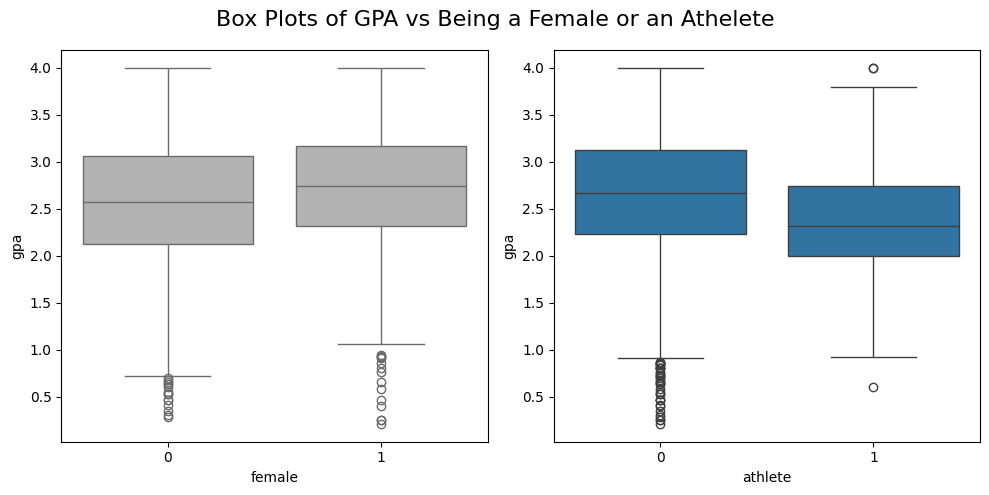

In [14]:
plt.figure(figsize=(12, 8))
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=0.5)
sns.boxplot(x='female', y='gpa', data=merged_df,ax=axes[0], color = (0.7,0.7,0.7))
sns.boxplot(x='athlete', y='gpa' , data=merged_df,ax=axes[1])
fig.suptitle('Box Plots of GPA vs Being a Female or an Athelete', fontsize=16)
plt.tight_layout()
plt.show()


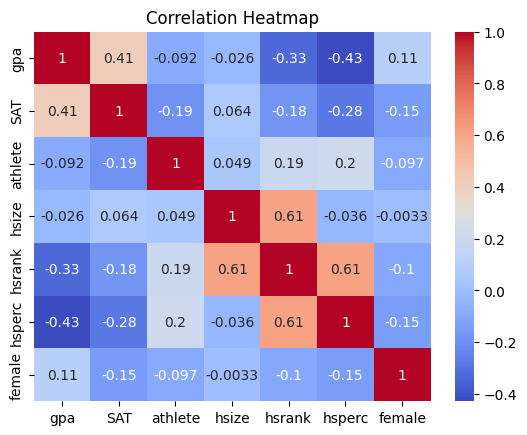

In [15]:
# Generate the correlation matrix
correlation_matrix = merged_df[['gpa', 'SAT', 'athlete','hsize','hsrank','hsperc','female']].corr()

# Generate a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


***
<strong><em>Initial Test Using All of The Dataset:</em></strong><br>
***

In [16]:
# Split data, we decided to drop hsperc as it is equal to rank/size --> dependent variable
X = merged_df[['SAT', 'athlete','hsize','hsrank','female']]
y = merged_df['gpa']

In [17]:
#Normal LinearRegression with k = 3 fold cross validation

best_mse = 17 #arbitrarly large MSE, (MSE for 0% accuracy is at maximum 16)
best_model = 0


kf = KFold(n_splits=3, random_state=None)
total_test_mse = 0
total_train_mse = 0
    
for j, (train_index, test_index) in enumerate(kf.split(X)):

    # Train Test split
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


    # Normalization
    mean_X_train = np.mean(X_train, axis=0)
    std_X_train = np.std(X_train, axis=0)
    mean_y_train = np.mean(y_train)
    std_y_train = np.std(y_train)


    X_train_norm = (X_train - mean_X_train)/std_X_train
    X_test_norm = (X_test - mean_X_train)/std_X_train

    y_train_norm = (y_train - mean_y_train)/std_y_train
    y_test_norm = (y_test - mean_y_train)/std_y_train

    # Linear Regression
    model = LinearRegression(fit_intercept= True)
    model.fit(X_train_norm, y_train_norm)

    # Train and test MSE
    y_train_predict_unnormalized = (model.predict(X_train_norm) * std_y_train) + mean_y_train
    y_test_predict_unnormalized = (model.predict(X_test_norm) * std_y_train) + mean_y_train

    train_mse = np.mean((y_train_predict_unnormalized - y_train) ** 2)
    test_mse = np.mean((y_test_predict_unnormalized - y_test) ** 2)
    total_train_mse += train_mse
    total_test_mse += test_mse

    if (test_mse < best_mse): #Choose the model with lowest MSE for hypothesis testing and R2 Calculation
        best_mse = test_mse
        best_model = model

print("Average Train MSE:", total_train_mse / kf.get_n_splits())
print("Average Test MSE:", total_test_mse / kf.get_n_splits())
print("Best model coeffecients: ", best_model.coef_)


Average Train MSE: 0.31040840158584354
Average Test MSE: 0.31604725075161383
Best model coeffecients:  [ 0.36375544  0.04964304  0.12845051 -0.34996969  0.14916353]


In [18]:
#ٌR2 Score Calculation

X_all_norm = (X - mean_X_train)/std_X_train
y_pred_all = best_model.predict(X_all_norm)
y_pred_all_unnormalized = (y_pred_all * std_y_train) + mean_y_train

print ("The r2 score is: ", r2_score(y,y_pred_all_unnormalized))

The r2 score is:  0.2751084818805395


In [19]:
#Hypothesis testing on the least error model

X_const_added = sm.add_constant(X_all_norm)
est = sm.OLS(y,X_all_norm)
est2 = est.fit()
print(est2.summary())


                                 OLS Regression Results                                
Dep. Variable:                    gpa   R-squared (uncentered):                   0.018
Model:                            OLS   Adj. R-squared (uncentered):              0.017
Method:                 Least Squares   F-statistic:                              15.50
Date:                Fri, 17 May 2024   Prob (F-statistic):                    3.92e-15
Time:                        20:05:08   Log-Likelihood:                         -9984.9
No. Observations:                4134   AIC:                                  1.998e+04
Df Residuals:                    4129   BIC:                                  2.001e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

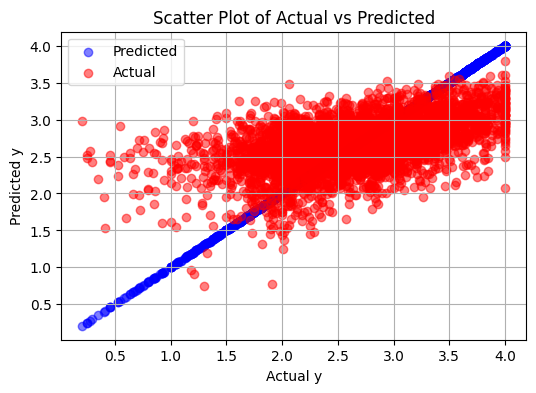

In [20]:
#Plotting a sample of 500 students


numss = [np.random.randint(1,len(y)) for _ in range(500)]
y_rand = y.iloc[numss]
y_pred_rand = y_pred_all_unnormalized[numss]

# Assuming y_pred_all_unnormalized and y are numpy arrays of the same length
plt.figure(figsize=(6, 4))
plt.scatter(y, y, color='blue', label='Predicted', alpha=0.5)
plt.scatter(y, y_pred_all_unnormalized, color='red', label='Actual', alpha=0.5)  # Actual values
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Scatter Plot of Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
best_mse = 10
best_model = 0

alphas = [0, 0.1,0.5, 1,10,100]

for i, alpha in enumerate(alphas):

    kf = KFold(n_splits=3, random_state=None)
    total_test_mse = 0
    total_train_mse = 0
        
    for j, (train_index, test_index) in enumerate(kf.split(X)):

        # Train Test split
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]


        # Normalization
        mean_X_train = np.mean(X_train, axis=0)
        std_X_train = np.std(X_train, axis=0)
        mean_y_train = np.mean(y_train)
        std_y_train = np.std(y_train)


        X_train_norm = (X_train - mean_X_train)/std_X_train
        X_test_norm = (X_test - mean_X_train)/std_X_train

        y_train_norm = (y_train - mean_y_train)/std_y_train
        y_test_norm = (y_test - mean_y_train)/std_y_train

        # Ridge Regression
        model = Ridge(alpha = alpha)
        model.fit(X_train_norm, y_train_norm)

        # Train and test MSE
        y_train_predict_unnormalized = (model.predict(X_train_norm) * std_y_train) + mean_y_train
        y_test_predict_unnormalized = (model.predict(X_test_norm) * std_y_train) + mean_y_train

        train_mse = np.mean((y_train_predict_unnormalized - y_train) ** 2)
        test_mse = np.mean((y_test_predict_unnormalized - y_test) ** 2)
        total_train_mse += train_mse
        total_test_mse += test_mse

        if (test_mse < best_mse):
            best_mse = test_mse
            best_model = model

    print("Average Train MSE:", total_train_mse / kf.get_n_splits())
    print("Average Test MSE:", total_test_mse / kf.get_n_splits())
    print()


Average Train MSE: 0.31040840158584354
Average Test MSE: 0.31604725075161383

Average Train MSE: 0.31040840185693025
Average Test MSE: 0.31604713717081717

Average Train MSE: 0.3104084083591218
Average Test MSE: 0.31604668865331675

Average Train MSE: 0.310408428659533
Average Test MSE: 0.31604614105053325

Average Train MSE: 0.3104110744250321
Average Test MSE: 0.3160387278578406

Average Train MSE: 0.31064514002420934
Average Test MSE: 0.3161871123802222



In [22]:
X_all_norm = (X - mean_X_train)/std_X_train
y_pred_all = best_model.predict(X_all_norm)
y_pred_all_unnormalized = (y_pred_all * std_y_train) + mean_y_train

print ("The r2 score is: ", r2_score(y,y_pred_all_unnormalized))

The r2 score is:  0.2751084818805396


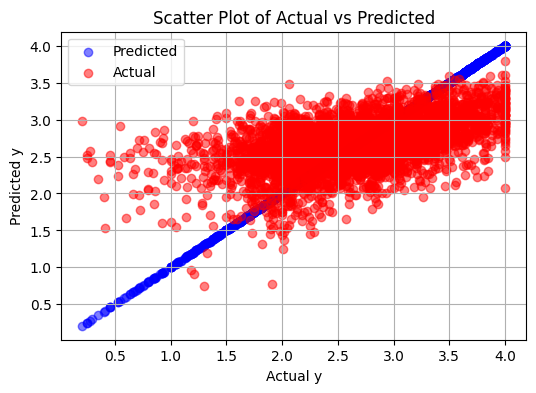

In [23]:
import matplotlib.pyplot as plt

numss = [np.random.randint(1,len(y)) for _ in range(500)]
y_rand = y.iloc[numss]
y_pred_rand = y_pred_all_unnormalized[numss]

# Assuming y_pred_all_unnormalized and y are numpy arrays of the same length
plt.figure(figsize=(6, 4))
plt.scatter(y, y, color='blue', label='Predicted', alpha=0.5)
plt.scatter(y, y_pred_all_unnormalized, color='red', label='Actual', alpha=0.5)  # Actual values
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Scatter Plot of Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
best_model = 0
best_mse = 10

# Normalization
mean_X_train = np.mean(X_train, axis=0)
std_X_train = np.std(X_train, axis=0)
mean_y_train = np.mean(y_train)
std_y_train = np.std(y_train)


X_train_norm = (X_train - mean_X_train)/std_X_train
X_test_norm = (X_test - mean_X_train)/std_X_train


y_train_norm = (y_train - mean_y_train)/std_y_train
y_test_norm = (y_test - mean_y_train)/std_y_train

degrees = [1,2,4,8]
alphas = [0.1,0.5,1,5,10]
for deg in degrees:

    # Polynomial Features
    poly = PolynomialFeatures(degree=deg, include_bias= True)  # You can adjust the degree as needed
    X_poly_train_norm = poly.fit_transform(X_train_norm)

    for alpha in alphas:
        model = Ridge(alpha=alpha)
        model.fit(X_poly_train_norm, y_train_norm)

        X_poly_test_norm = poly.fit_transform(X_test_norm)


        train_mse = mean_squared_error(y_train, (model.predict(X_poly_train_norm)*std_y_train)+mean_y_train)
        test_mse = mean_squared_error(y_test, (model.predict(X_poly_test_norm)*std_y_train)+mean_y_train)
        
        if (test_mse < best_mse):
            best_mse = test_mse
            best_model = model
            best_poly = poly

c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=7.28663e-18): result may not be accurate.

c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=3.60945e-17): result may not be accurate.

c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=7.18415e-17): result may not be accurate.



The r2 score is:  0.3230237692455552


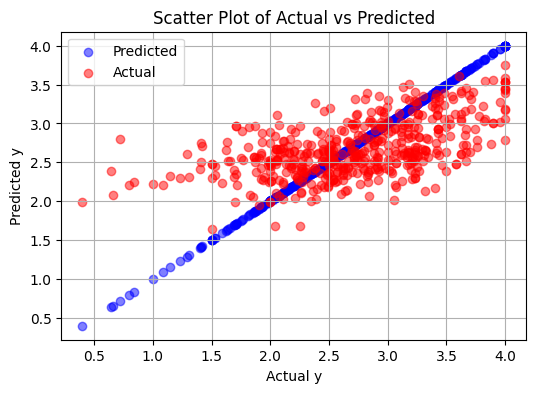

The r2 score is:  0.3230237692455552


In [25]:
X_norm = (X - mean_X_train)/std_X_train
X_poly = best_poly.fit_transform(X_norm)
y_pred_all_unnormalized = (best_model.predict(X_poly)*std_y_train)+mean_y_train

print ("The r2 score is: ", r2_score(y,y_pred_all_unnormalized))

numss = [np.random.randint(1,len(y)) for _ in range(500)]
y_rand = y.iloc[numss]
y_pred_rand = y_pred_all_unnormalized[numss]

# Assuming y_pred_all_unnormalized and y are numpy arrays of the same length
plt.figure(figsize=(6, 4))
plt.scatter(y_rand, y_rand, color='blue', label='Predicted', alpha=0.5)
plt.scatter(y_rand, y_pred_rand, color='red', label='Actual', alpha=0.5)  # Actual values
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Scatter Plot of Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()
print ("The r2 score is: ", r2_score(y,y_pred_all_unnormalized))


REMOVING OUTLIERS

In [26]:
change = 25

first_quartile = np.percentile(y, change)
fourth_quartile = np.percentile(y, 100-change)

iqr = fourth_quartile - first_quartile

lower_bound = first_quartile - 1.5 * iqr
upper_bound = fourth_quartile + 1.5 * iqr

outlier_indices = np.where((y < lower_bound) | (y > upper_bound))[0]

merged_df_no_OUT = merged_df[(merged_df['gpa'] > lower_bound) & (merged_df['gpa'] < upper_bound)]


X_no_outliers = merged_df_no_OUT[['SAT', 'athlete','hsize','hsrank','hsperc','female']]
y_no_outliers = merged_df_no_OUT['gpa']


In [27]:
best_mse = 10
best_model = 0


kf = KFold(n_splits=3, random_state=None)
total_test_mse = 0
total_train_mse = 0
    
for j, (train_index, test_index) in enumerate(kf.split(X_no_outliers)):

    # Train Test split
    X_train, X_test = X_no_outliers.iloc[train_index], X_no_outliers.iloc[test_index]
    y_train, y_test = y_no_outliers.iloc[train_index], y_no_outliers.iloc[test_index]


    # Normalization
    mean_X_train = np.mean(X_train, axis=0)
    std_X_train = np.std(X_train, axis=0)
    mean_y_train = np.mean(y_train)
    std_y_train = np.std(y_train)


    X_train_norm = (X_train - mean_X_train)/std_X_train
    X_test_norm = (X_test - mean_X_train)/std_X_train

    y_train_norm = (y_train - mean_y_train)/std_y_train
    y_test_norm = (y_test - mean_y_train)/std_y_train

    # Linear Regression
    model = LinearRegression()
    model.fit(X_train_norm, y_train_norm)

    # Train and test MSE
    y_train_predict_unnormalized = (model.predict(X_train_norm) * std_y_train) + mean_y_train
    y_test_predict_unnormalized = (model.predict(X_test_norm) * std_y_train) + mean_y_train

    train_mse = np.mean((y_train_predict_unnormalized - y_train) ** 2)
    test_mse = np.mean((y_test_predict_unnormalized - y_test) ** 2)
    total_train_mse += train_mse
    total_test_mse += test_mse

    if (test_mse < best_mse):
        best_mse = test_mse
        best_model = model

print("Average Train MSE:", total_train_mse / kf.get_n_splits())
print("Average Test MSE:", total_test_mse / kf.get_n_splits())


Average Train MSE: 0.27882171398083905
Average Test MSE: 0.2845323214598053


In [28]:
X_all_norm = (X_no_outliers - mean_X_train)/std_X_train
y_pred_all = best_model.predict(X_all_norm)
y_pred_all_unnormalized = (y_pred_all * std_y_train) + mean_y_train

print ("The r2 score is: ", r2_score(y_no_outliers,y_pred_all_unnormalized))

The r2 score is:  0.2979862177884639


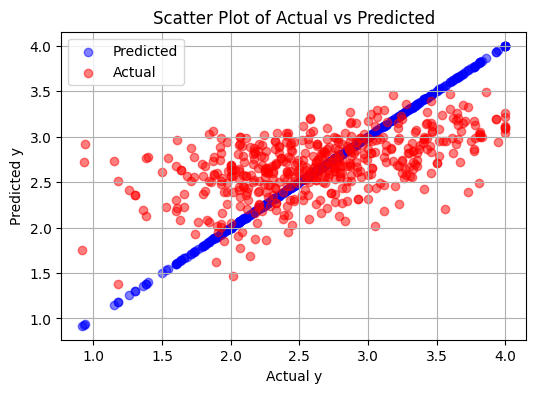

In [29]:
numss = [np.random.randint(1,len(y_no_outliers)) for _ in range(500)]
y_rand = y_no_outliers.iloc[numss]
y_pred_rand = y_pred_all_unnormalized[numss]

# Assuming y_pred_all_unnormalized and y are numpy arrays of the same length
plt.figure(figsize=(6, 4))
plt.scatter(y_rand, y_rand, color='blue', label='Predicted', alpha=0.5)
plt.scatter(y_rand, y_pred_rand, color='red', label='Actual', alpha=0.5)  # Actual values
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Scatter Plot of Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_no_outliers, y_no_outliers, test_size=0.2, random_state=50)
best_model = 0
best_mse = 10

# Normalization
mean_X_train = np.mean(X_train, axis=0)
std_X_train = np.std(X_train, axis=0)
mean_y_train = np.mean(y_train)
std_y_train = np.std(y_train)


X_train_norm = (X_train - mean_X_train)/std_X_train
X_test_norm = (X_test - mean_X_train)/std_X_train


y_train_norm = (y_train - mean_y_train)/std_y_train
y_test_norm = (y_test - mean_y_train)/std_y_train

degrees = [1,2,4,8]
alphas = [0.1,0.5,1,5,10]
for deg in degrees:

    # Polynomial Features
    poly = PolynomialFeatures(degree=deg, include_bias= True)  # You can adjust the degree as needed
    X_poly_train_norm = poly.fit_transform(X_train_norm)

    for alpha in alphas:
        model = Ridge(alpha=alpha)
        model.fit(X_poly_train_norm, y_train_norm)

        X_poly_test_norm = poly.fit_transform(X_test_norm)


        train_mse = mean_squared_error(y_train, (model.predict(X_poly_train_norm)*std_y_train)+mean_y_train)
        test_mse = mean_squared_error(y_test, (model.predict(X_poly_test_norm)*std_y_train)+mean_y_train)
        
        if (test_mse < best_mse):
            best_mse = test_mse
            best_model = model
            best_poly = poly

c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=3.36816e-18): result may not be accurate.

c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=1.67951e-17): result may not be accurate.

c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=3.35387e-17): result may not be accurate.



In [31]:
X_norm = (X_no_outliers - mean_X_train)/std_X_train
X_poly = best_poly.fit_transform(X_norm)
y_pred_all_unnormalized = (best_model.predict(X_poly)*std_y_train)+mean_y_train

print ("The r2 score is: ", r2_score(y_no_outliers,y_pred_all_unnormalized))


The r2 score is:  0.32130075720068174


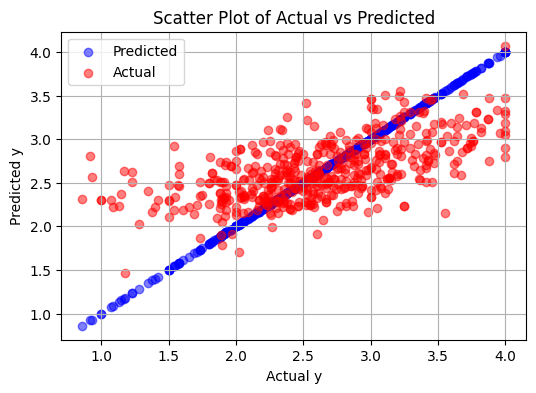

In [32]:
numss = [np.random.randint(1,len(y_no_outliers)) for _ in range(500)]
y_rand = y_no_outliers.iloc[numss]
y_pred_rand = y_pred_all_unnormalized[numss]

# Assuming y_pred_all_unnormalized and y are numpy arrays of the same length
plt.figure(figsize=(6, 4))
plt.scatter(y_rand, y_rand, color='blue', label='Predicted', alpha=0.5)
plt.scatter(y_rand, y_pred_rand, color='red', label='Actual', alpha=0.5)  # Actual values
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Scatter Plot of Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

Following commented code got cleaned in the above.


HERE STARTS CLASSIFICATION CODE CLEANING


In [33]:
X = merged_df[['SAT', 'athlete','hsize','hsrank','female']] #Same concept here, dropping feature hs percentile as it is dependent on rank and size
y = merged_df['Success']

# Train-test split
def KNNClassification(k):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
    model = KNeighborsClassifier(n_neighbors= 5)

    #Normalization
    mean_X_train = np.mean(X_train, axis=0)
    std_X_train = np.std(X_train, axis=0)


    X_train_norm = (X_train-mean_X_train)/std_X_train


    model.fit(X_train_norm,y_train)

    X_test_norm = (X_test - mean_X_train)/ std_X_train


    y_pred = model.predict(X_test_norm)

    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Fail", "Success"],)
    cm_display.plot(cmap = "YlOrRd")
    plt.show()

    print(model.score(X_test_norm, y_test))

In [34]:
def LogisticRegressionClassification(alphaValue):
    model = LogisticRegression(random_state=0, C=0.01,fit_intercept=True)
    model.fit(X_train_norm, y_train)

    y_pred = model.predict(X_test_norm)
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Fail", "Success"],)
    cm_display.plot(cmap = "BuPu")
    plt.show()

    print(model.score(X_test_norm, y_test))

In [35]:
def supportVectorClassifier():
    model = SVC(kernel='rbf', probability=True)
    model.fit(X_train_norm, y_train)

    y_pred = model.predict(X_test_norm)
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Fail", "Success"],)
    cm_display.plot(cmap = "binary")
    plt.show()

    print(model.score(X_test_norm, y_test))


1. Coorelation testing - Heatmaps, pair plots, hypothesis testing,  qq plot 
2. EDA
3. EDA models 
4. Report 

5 (Extra). Understand models extensively



REPORT Ta2SEEMA:
Abstract:
Introduction --> Literature Review:
Methodology --> Code Explanation - Materials and methods:
Results ---> Compare with the github repo:
Conclusion:
References
